In [1]:
"""
@author Ryan Williams
     
     Notebook 5 - Feature Engineering methods

@date June-October, 2021
"""

'\n@author Ryan Williams\n     \n     Notebook 5 - Feature Engineering methods\n\n@date June-July, 2021\n'

# Notebook 5 - Feature Engineering methods

**Aim:** This notebook applies each feature extraction method to the preprocessed datasest created within Notebook 4. With each feature extraction method creating a seperate dataset. Start with one dataset, end with four.

**Summary:** 
- Import necessary packages.
- Import the preprocessed data which we created within notebook 4.
- Remove highly correlated and non-useful features, this is informed by our experiments within Notebook 2.
- Save a base version of this dataset without these features.
- Add features to allign with the SIRS criteria.
- Save the dataset with the SIRS features.
- Apply PCA to create a different enriched datasest.
- Save the PCA dataset.
- Apply the FRESH algorithm to create a different enriched datasest.
- Save the FRESH dataset.

Import necessary packages.

In [1]:
# Imports
import numpy as np  # for some maths operations
import pandas as pd # for using pandas daraframe
import matplotlib.pyplot as plt # For plotting
from sklearn.decomposition import PCA # For PCA feature engineering
from tsfresh import extract_relevant_features  # For FRESH feature extraction
from sklearn.preprocessing import StandardScaler # for standardizing the Data
from tsfresh.feature_extraction import MinimalFCParameters  # For FRESH parameters

import warnings  # To be able to ignore some warnings
warnings.filterwarnings('ignore')

Define the output directory for the figures we will create.

In [2]:
# Define directory to save Figures as images too by defualt
figures_directory = './sepsis-detection/notebooks/Notebook 5 - Feature Engineering methods/figures/'

Import the preprocessed data which we created within notebook 4.

In [3]:
# Lets import the base preprocessed dataset created within Notebook 4. 
processed_dataset = pd.read_pickle('./sepsis-detection/data/interim/from Notebook 4/processed_dataset.pkl')

# SIRS criteria

Add addtional features based on the presence of the SIRS criteria:

Clinically, the Systemic Inflammatory Response Syndrome (SIRS) is the occurrence of at least two of the following criteria: fever >38.0°C or hypothermia <36.0°C, tachycardia >90 beats/minute, tachypnea >20 breaths/minute, leucocytosis >12*109/l or leucopoenia <4*109/l

 (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2806258/#:~:text=Clinically%2C%20the%20Systemic%20Inflammatory%20Response%20Syndrome%20(SIRS)%20is%20the,l%20%5B1%2C2%5D.)

In [7]:
# Create copy of engineered dataset.
dataset_SIRS = dataset_engineered.copy()

# Import WBC
dataset_SIRS['WBC'] = processed_dataset['WBC']

# Check for the presence of criteria 1 
# (fever >38.0°C or hypothermia <36.0°C)
dataset_SIRS['SIRS_temp'] = np.where((dataset_SIRS['Temp'] > 38) | (dataset_SIRS['Temp'] < 36), 1, 0)

# Check for the presence of criteria 2 
# (tachycardia >90 beats/minute)
dataset_SIRS['SIRS_HR'] = np.where(dataset_SIRS['HR'] > 90, 1, 0)

# Check for the presence of criteria 3 
# (tachypnea >20 breaths/minute)
dataset_SIRS['SIRS_resp'] = np.where(dataset_SIRS['Resp'] > 20, 1, 0)

# Check for the presence of criteria  4 
# (leucocytosis >12*109/l or leucopoenia <4*109/l)
dataset_SIRS['SIRS_wbc'] = np.where((dataset_SIRS['WBC'] > 12) | (dataset_SIRS['WBC'] < 4), 1, 0)

# Add a column to show if SIRS criteria are met for a positive diagnosis
# 2 or more criteria positive
dataset_SIRS['SIRS'] = np.where((dataset_SIRS['SIRS_temp'] + dataset_SIRS['SIRS_HR'] + dataset_SIRS['SIRS_resp'] + dataset_SIRS['SIRS_wbc'])>= 2, 1, 0)

Lets save this new dataset so it can be used later on 

In [8]:
# Lets save this as a sperate dataset 
dataset_SIRS.to_pickle('./sepsis-detection/data/interim/from Notebook 5/SIRS_dataset.pkl')

# Apply PCA 

Standardise our dataset and fit PCA to determine the amount of components required.

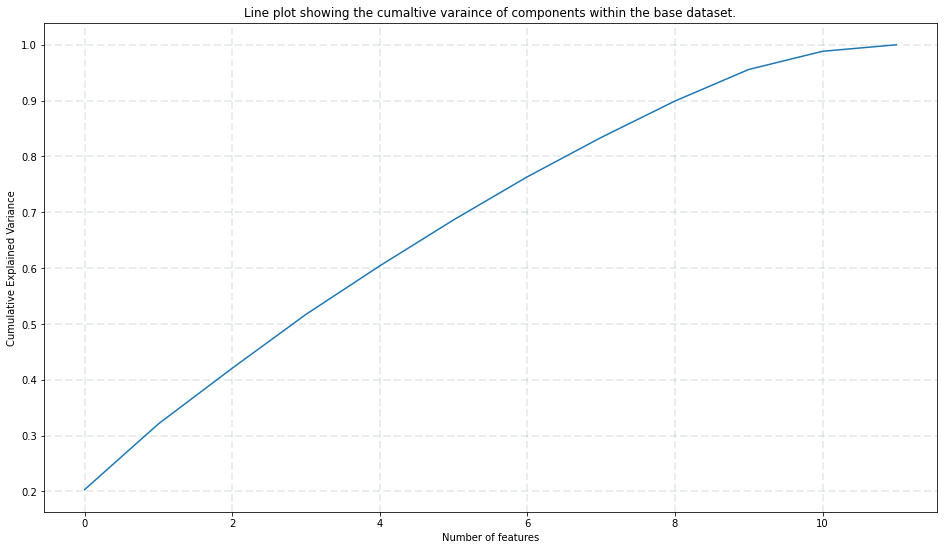

In [8]:
# Create copy of the engineered dataset
dataset_PCA = dataset_engineered.copy()

# Standardise the data, removing patientID as it not a numerical
# value and thus cannot be standardised 
sc = StandardScaler() 
standdardised_dataset = sc.fit_transform(dataset_PCA.drop(columns=['patientID','SepsisLabel']).values) 

# Define our defualt PCA method with all of the features included 
pca = PCA()
dataset_pca = pca.fit(standdardised_dataset)

# Lets plot a graph to help us decide on the number of PCA 
# Define figure's size, type and grid overlay
plt.figure(figsize=(16, 9))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.2)
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='x', alpha=0.2)
# Define the axis labels and properties
plt.title('Line plot showing the cumaltive varaince of components within the base dataset.')
plt.xlabel('Number of features')
plt.locator_params(axis='y', nbins=10)
plt.ylabel('Cumulative Explained Variance')
# Save our figure and then show
plt.savefig(figures_directory+'PCA_componant_variance.jpg')
plt.show()

Apply PCA

In [10]:
# Alter number of components based on interpretation of above figure
num_components = 10

pca = PCA(num_components)  
dataset_pca = pca.fit_transform(standdardised_dataset)

n_pcs = pca.n_components_ # get number of component
# get the index of the most important feature on EACH component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = dataset_PCA.drop(columns=['patientID', 'SepsisLabel']).columns
# get the most important feature names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# Remove all but specified columns
dataset_PCA = dataset_PCA[most_important_names + ['patientID', 'SepsisLabel']]

Lets save this new dataset so it can be used later on 

In [11]:
# Lets save this as a sperate dataset
dataset_PCA.to_pickle('./sepsis-detection/data/interim/from Notebook 5/PCA_dataset.pkl')

# Apply FRESH

In [12]:
# Define the non-time variant features to not include for FRESH 
non_time_var = ['Unit1', 'Gender', 'HospAdmTime', 'Age']

# Create copy of the engineered dataset.
dataset_FRESH = (dataset_engineered.copy())

# Add a time feature to be able to better transverse our data.
times = [] 
for item in dataset_FRESH['patientID'].value_counts().sort_index().to_list():
    for i in range(item):
        times.append(i)
dataset_FRESH['time'] = times

# Create series containing the outcomes for each patient, set to True or False. 
y = pd.Series((dataset_FRESH.loc[dataset_FRESH['patientID'].isin(dataset_FRESH['patientID'].drop_duplicates())].groupby('patientID').tail(1)['SepsisLabel']).to_list(), index=dataset_FRESH['patientID'].drop_duplicates() ).apply(lambda x: True if x == 1 else False)

# Extract all possible features and only keep the useful features that effect outcome.
features_filtered = extract_relevant_features(dataset_FRESH.drop(columns=(['SepsisLabel']+non_time_var)), y, column_id="patientID", column_sort="time", default_fc_parameters=MinimalFCParameters())

Feature Extraction: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:50<00:00,  1.67s/it]


Add the extracted columns into our dataset

In [13]:
# Change the index of features_filtered and add patientID so we can merge
features_filtered['patientID'] = dataset_FRESH['patientID'].drop_duplicates().to_list()
features_filtered = features_filtered.reset_index(drop=True)

# Add the features from FRESH along patientID
dataset_FRESH = dataset_FRESH.merge(features_filtered, on='patientID')

Lets save this new dataset so it can be used later on 

In [14]:
# Lets save this as a sperate dataset 
dataset_FRESH.to_pickle('./sepsis-detection/data/interim/from Notebook 5/FRESH_dataset.pkl')